In [1]:
%pylab inline
import pandas as pd
import numpy as np
import fastai
import torch
from pathlib import Path
import PIL
import tqdm
import os
import json
tqdm.monitor_interval = 0

Populating the interactive namespace from numpy and matplotlib


In [2]:
from fastai.conv_learner import resnet34, resnet152, transforms_top_down, CropType, \
    tfms_from_model, ConvLearner, optim, T
from fastai.dataset import ImageClassifierData, Denormalize
from fastai.sgdr import TrainingPhase, DecayType
from lifelines.utils import concordance_index

In [3]:
def cindex_metric(preds, targs):
    try:
        cindex = concordance_index(preds, targs)
    except:
        cindex = 0.0
    return cindex

In [4]:
torch.backends.cudnn.benchmark=True
torch.cuda.set_device(1)
torch.cuda.current_device()


1

In [5]:
LIVER_PATH = Path('/DATA/BIO/GDC/liver')
LIVER_SAMPLES = LIVER_PATH/"samples"
EXP_PATH = LIVER_PATH/"exp1"
EXP_MODEL_PATH = EXP_PATH/"models"
EXP_DATA = EXP_PATH/"data"
EXP_TRAIN_DATA = EXP_DATA/"train"
EXP_TEST_DATA = EXP_DATA/"test"
PATIENT_JSON = EXP_PATH/'patient_split.json'
TRAIN_CSV = EXP_PATH/'level_1_train.csv'
TRAIN_CSV_FULL = EXP_PATH/'level_1_train_full.csv'
TEST_CSV = EXP_PATH/'level_1_test.csv'
TEST_CSV_FULL = EXP_PATH/'level_1_test_FULL.csv'

for d in [EXP_PATH, EXP_DATA, EXP_TRAIN_DATA, EXP_TEST_DATA, EXP_MODEL_PATH]:
    if not d.exists():
        d.mkdir()

In [6]:
slides = pd.read_csv(LIVER_PATH/'slides.csv')
def get_tissue_type(x):
    return x.split('-')[4]

tissue_type = slides.slide_file_name.apply(get_tissue_type)
slides = slides.loc[tissue_type == '01',:].copy()

In [7]:
try:
    with open(PATIENT_JSON, 'r') as fobj:
        patients = json.load(fobj)
        train_patients = patients['train']
        val_patients = patients['val']
        test_patients = patients['test']
    train_slides = slides.loc[slides.submitter_id.isin(train_patients)]
    test_slides = slides.loc[slides.submitter_id.isin(test_patients)]

    train_csv_df = pd.read_csv(TRAIN_CSV_FULL)
    val_idx = train_csv_df.loc[train_csv_df.val_patient].index
except:
    slides['days_proxy'] = slides.days_to_death.fillna(slides.days_to_last_follow_up)
    slides = slides.loc[slides.days_proxy.notnull()].copy()
    patients = random.permutation(list(set(slides.submitter_id)))
    split = int(0.95 * len(patients))
    val_split = int(0.8 * split)
    train_patients = patients[:split]
    val_patients = patients[val_split:split]
    test_patients = patients[split:]

    patient_split = {
        'train': list(train_patients),
        'val': list(val_patients),
        'test': list(test_patients)
    }
    with open(EXP_PATH/'patient_split.json', 'w') as fobj:
        json.dump(patient_split, fobj)

    len(train_patients), len(val_patients), len(test_patients)
    
    train_slides = slides.loc[slides.submitter_id.isin(train_patients)]
    test_slides = slides.loc[slides.submitter_id.isin(test_patients)]
    
    
    train_items = []
    test_items = []
    num_slides = []
    samples_per_slide = 50
    for ix, patient in tqdm.tqdm_notebook(slides.iterrows(), total=len(slides)):
        sfp = LIVER_SAMPLES/patient.slide_file_name.upper()/"level_1"
        sample_files = list(sfp.iterdir())
        num_samples = len(sample_files)
        num_slides.append(num_samples)
        for fn in np.random.choice(sample_files, size=min(samples_per_slide,num_samples), replace=False):
            if patient.submitter_id in train_patients:
                dest_path = EXP_TRAIN_DATA
                train = True
                if patient.submitter_id in val_patients:
                    val = True
                else:
                    val = False
            else:
                dest_path = EXP_TEST_DATA
                train = False

            slide_id = os.path.basename(patient.slide_file_name).split('.')[0]
            img_id = os.path.basename(fn).split('.')[0]
            new_fn_base = '-'.join([slide_id, img_id]) + '.tiff'
            full_path = dest_path/new_fn_base

            if not full_path.exists():
                os.symlink(fn, dest_path/new_fn_base)

            if train:
                train_items.append({
                    'fn': str(new_fn_base),
                    'val': patient.days_proxy,
                    'val_patient': val,
                    'patient_id': patient.submitter_id
                })
            else:
                test_items.append({
                    'fn': str(new_fn_base),
                    'val': patient.days_proxy,
                    'patient_id': patient.submitter_id
                })
                
    train_csv_df = pd.DataFrame(list(random.permutation(train_items)))
    
    train_csv_df[['fn','val']].to_csv(TRAIN_CSV, index=False)
    train_csv_df.to_csv(TRAIN_CSV_FULL, index=False)
    val_idx = train_csv_df.loc[train_csv_df.val_patient].index

    test_csv_df = pd.DataFrame(test_items)
    test_csv_df[['fn','val']].to_csv(TEST_CSV, index=False)
    test_csv_df.to_csv(TEST_CSV_FULL, index=False)

In [8]:
f_model = resnet34
sz=256
bs=16
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, crop_type=CropType.CENTER)
md = ImageClassifierData.from_csv(
    EXP_PATH, "data/train", TRAIN_CSV, tfms=tfms, bs=bs, val_idxs=val_idx, continuous=True
)

In [9]:
try:
    test_csv_df
except NameError:
    test_csv_df = pd.read_csv(TEST_CSV_FULL)
    
md_test = ImageClassifierData.from_csv(
    EXP_PATH, "data/test", TEST_CSV, tfms=tfms, bs=bs, val_idxs=test_csv_df.index, continuous=True
)

In [10]:
from fastai.layers import AdaptiveConcatPool2d,Flatten
from torch.nn import BatchNorm1d,Dropout,ReLU,Linear,Sequential

layers = [AdaptiveConcatPool2d(), Flatten()]
layers += [BatchNorm1d(1024),
            Dropout(p=0.25), 
            Linear(in_features=1024, out_features=512), 
            ReLU(), 
            BatchNorm1d(512),
            Dropout(p=0.5), 
            Linear(in_features=512, out_features=1),
            ReLU()]
head_relu = Sequential(*layers)

In [11]:
learn = ConvLearner.pretrained(f_model, md,custom_head=head_relu)
learn.opt_fn = optim.Adam

In [12]:
learn.children[-10:]

[Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
 ReLU(inplace),
 MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1)),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
     (relu): ReLU(inplace)
     (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
     (relu): ReLU(inplace)
     (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
   )
   (2): BasicBl

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                               
    0      884.27318  867.828608



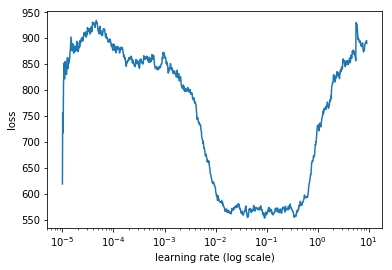

In [14]:
# set to true to try learning rate finder
if True:
    learn.save('tmp')
    lrf=learn.lr_find()
    learn.sched.plot(0)
    learn.load('tmp')

In [ ]:
lr = 0.001
learn.fit(lr, 4, cycle_len=5, use_clr=(32,5), best_save_name='liver_best_1', metrics=[cindex_metric])
learn.save('liver_1')

HBox(children=(IntProgress(value=0, description='Epoch', max=20), HTML(value='')))

epoch      trn_loss   val_loss   cindex_metric               
    0      648.825593 620.505875 0.502903  
    1      559.562307 542.824476 0.514515                    
    2      541.289437 541.239179 0.512317                    
 14%|█▎        | 155/1137 [00:05<00:35, 27.67it/s, loss=521]

In [ ]:
lrs = np.array([lr/1000, lr/100, lr])
learn.freeze_to(-2)
learn.fit(lrs, 10, cycle_len=10, use_clr=(32,10), best_save_name='liver_best_4', metrics=[cindex_metric])
learn.save('liver_4')

In [ ]:
from torch.autograd import Variable
def eval_model(learn, model_name):
    learn.save('tmp')
    learn.load(model_name)
    y_pred, y_targ = learn.predict_with_targs()
    learn.load('tmp')
#    return learn.crit(T(y_pred), T(y_targ)), cindex_metric(y_pred, y_targ)
    crit_data = learn.crit(Variable(T(y_pred)),Variable(T(y_targ))).data[0]
    return crit_data,cindex_metric(y_pred, y_targ)

In [ ]:
for mname in ['liver_1', 'liver_best_1'
              ,'liver_4', 'liver_best_4'
              #,'liver_5', 'liver_best_5'
             ]:
    print(mname,eval_model(learn, mname))

In [ ]:
learn.load('liver_best_4')

In [ ]:
y_pred = learn.predict_dl(md_test.val_dl)
test_df = test_csv_df.copy()
test_df['y_pred'] = y_pred

y_pred.shape, test_df.shape

In [ ]:
yp_pred = test_df.groupby('patient_id').y_pred.min()
yp_targ = test_df.groupby('patient_id').val.mean()

In [ ]:
concordance_index(yp_pred, yp_targ )

In [ ]:
learn.crit(Variable(T(yp_pred)), Variable(T(yp_targ)))

In [ ]:
scatter(yp_targ, yp_pred)

In [ ]:
test_df.val.hist()

In [ ]:
train_csv_df.val.hist()